<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/tests_results_and_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Kernel setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb
!pip install pmdarima
!pip install arch

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [ ]:
%%capture
!cd npmf && git pull

import os
import pickle
import json
from collections import defaultdict, OrderedDict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import legend

from tqdm import tqdm

import pmdarima as pm

import arch 

import wandb as wb

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, put_dataset, put_stat_models, get_stat_models
from npmf.utils.data import test_start_pd, get_1_month_test_set, get_train_set
from npmf.utils.measurement import mape
from npmf.utils.eikon import col_map_macro

In [ ]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (12, 4)  # (6, 4) is default and used in the paper
pd.DataFrame.np = lambda self: self.to_numpy()
pd.Series.np = lambda self: self.to_numpy()

In [ ]:
np.random.seed(420)

## Helper functions

In [ ]:
def plot_market_cap(df):
    plt.plot(df.date.to_numpy(), df.market_cap.to_numpy())

In [ ]:
def worst_plot_data(err, worst):
    ts = []
    mapes = []

    for i, t in enumerate(worst[:25], start=1):
        ts.append(f"{i}: {t}")
        mapes.append(reduce(err[err.index.get_level_values(0) == t]))
    
    return ts, mapes

In [ ]:
def plot_worst(ts, loss_df, idx, lf_name):
    mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper
    cutoff = idx - 1

    plt.plot(ts, loss_df, label="Mean loss", color=main2)
    plt.plot(ts[cutoff:], loss_df[cutoff:], color=main)

    plt.xticks(ts, rotation='vertical')
    plt.axhline(y=loss_df[cutoff], color="lightgrey", label=f"{lf_name} {loss_df[cutoff]*100:.0f}%")
    plt.axvline(x=cutoff, color="grey", label="Worst 1%", linestyle="-.")
    plt.yscale("log")
    plt.xlabel(f"Companies by mean {lf_name}, descending")
    plt.ylabel(f"Mean {lf_name} loss over each company")

    plt.legend(frameon=False);

Helper functions for calculation

In [ ]:
def pd_mae(a,f):
    return (a - f).abs()

def pd_mape(a, f):
    return ((a - f).abs() / a.abs())

def reduce(err):
    return err.groupby(level=[0, 1, 2]).mean().mean().item()

In [ ]:
def get_losses(loss_fn, actuals, forecasts, percentage_best=0.01):
    nae = loss_fn(actuals, forecasts)
    naw = nae.dropna().groupby(level=0).mean().sort_values(by="sdev", ascending=False).index.get_level_values(0).unique()
    na1 = int(len(naw) * percentage_best)
    

    p_worst_mean = nae[~nae.index.get_level_values(0).isin(naw[:na1])].mean()
    return nae.mean(), p_worst_mean

# Prepare test set

## Get data from WB

In [ ]:
%%capture
reload_stock_data = not True
reload_macro_data = not True

if reload_stock_data or not "all_stck" in vars():
    all_stck = get_dataset("stock-data:final", "master").drop(columns=["close_price", "currency"]).astype(dict(market_cap=np.float32)).query("date >= '2000-01-01'")

if reload_macro_data or "macro" not in vars(): 
    macro = get_dataset("macro-data:final", "master").query("date >= '2000-01-01'")

In [ ]:
stck = all_stck[all_stck.date >= "2019-01-01"]

## Create actual

In [ ]:
stck

,ticker,date,market_cap
4595,000001.SZ,2019-01-02,2.300335e+10
4596,000001.SZ,2019-01-03,2.319110e+10
4597,000001.SZ,2019-01-04,2.438162e+10
4598,000001.SZ,2019-01-07,2.441421e+10
4599,000001.SZ,2019-01-08,2.420733e+10
...,...,...,...
6969374,ZION.OQ,2022-04-14,9.557202e+09
6969375,ZION.OQ,2022-04-18,9.672642e+09
6969376,ZION.OQ,2022-04-19,9.953647e+09
6969377,ZION.OQ,2022-04-20,9.906559e+09


In [ ]:
stck["year"], stck["month"] = stck["date"].dt.year, stck["date"].dt.month
stck["obs_number"] = stck.groupby(by=["ticker", "year", "month"]).date.rank(method='first', ascending=True).astype(int)
actuals = stck[stck.obs_number <= 20].drop(columns=["date"]).set_index(["ticker", "year", "month", "obs_number"]).sort_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
actuals

market_cap
ticker    year month obs_number              
000001.SZ 2019 1     1           2.300335e+10
                     2           2.319110e+10
                     3           2.438162e+10
                     4           2.441421e+10
                     5           2.420733e+10
...                                       ...
ZION.OQ   2022 4     10          9.557202e+09
                     11          9.672642e+09
                     12          9.953647e+09
                     13          9.906559e+09
                     14          9.452394e+09

[1314152 rows x 1 columns]

## Create actual std

In [ ]:
stds = actuals.groupby(level=["ticker", "year", "month"]).pct_change().groupby(level=["ticker", "year", "month"]).std().rename(columns={"market_cap":"sdev"})
stds

sdev
ticker    year month          
000001.SZ 2019 1      0.020456
               2      0.030604
               3      0.017715
               4      0.024458
               5      0.022656
...                        ...
ZION.OQ   2021 12     0.021822
          2022 1      0.025694
               2      0.025366
               3      0.028557
               4      0.018526

[67620 rows x 1 columns]

# Market cap

## Baseline

### Naïve

In [ ]:
naive = all_stck[(all_stck.date > "2018-12-01") & (all_stck.date < "2022-04-01")].copy()
naive["year"], naive["month"] = naive["date"].dt.year, naive["date"].dt.month
naive = naive.drop(columns=["date"])

naive = naive.groupby(by=["ticker", "year", "month"]).last(1).reset_index()

naive["month"] = naive["month"] + 1
adj = naive.month == 13
naive.loc[adj, "month"] = 1
naive.loc[adj, "year"] = naive.loc[adj, "year"] + 1

naive = naive.set_index(["ticker", "year", "month"]).sort_index()

In [ ]:
naive

market_cap
ticker    year month              
000001.SZ 2019 1      2.342498e+10
               2      2.846435e+10
               3      3.171722e+10
               4      3.279960e+10
               5      3.531118e+10
...                            ...
ZION.OQ   2021 12     9.869715e+09
          2022 1      9.882233e+09
               2      1.061135e+10
               3      1.076780e+10
               4      9.958203e+09

[67576 rows x 1 columns]

In [ ]:
nae = pd_mape(actuals, naive)
reduce(nae)

0.06945216655731201

In [ ]:
naw = nae.dropna().groupby(level=0).mean().sort_values(by="market_cap", ascending=False).index.get_level_values(0).unique()
na1 = int(len(naw) * 0.01)
na1

17

In [ ]:
reduce(nae[~nae.index.get_level_values(0).isin(naw[:na1])])

0.06804552674293518

In [ ]:
nats, namapes = worst_plot_data(nae, naw)

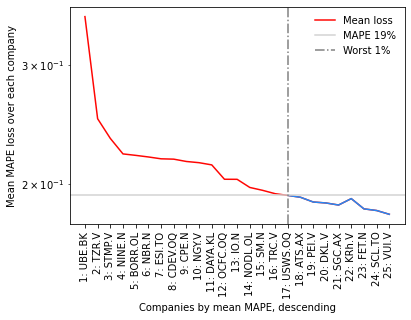

In [ ]:
plot_worst(nats, namapes, na1)

## Parametric

### ARIMA

In [ ]:
%%capture
arima = get_dataset("auto-arima-4Q-forecast-19-22:v1", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()

In [ ]:
arima

market_cap
ticker    year month obs_number              
000001.SZ 2019 1     1           2.338070e+10
                     2           2.343430e+10
                     3           2.337984e+10
                     4           2.333328e+10
                     5           2.338126e+10
...                                       ...
ZION.OQ   2022 4     16          9.958204e+09
                     17          9.958204e+09
                     18          9.958204e+09
                     19          9.958204e+09
                     20          9.958204e+09

[1329600 rows x 1 columns]

In [ ]:
ae = pd_mape(actuals, arima)
reduce(ae)

0.07932105925530383

In [ ]:
aw = ae.dropna().groupby(level=0).mean().sort_values(by="market_cap", ascending=False).index.get_level_values(0).unique()
a1 = int(len(aw) * 0.01)
a1

16

In [ ]:
reduce(ae[~ae.index.get_level_values(0).isin(aw[:a1])])

0.07444388130247029

In [ ]:
ats, amapes = worst_plot_data(ae, aw)

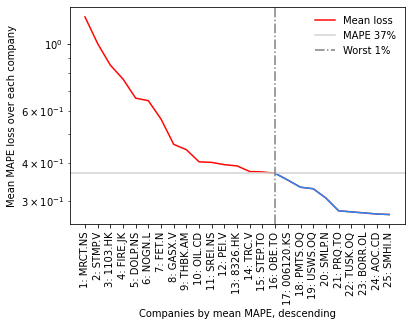

In [ ]:
plot_worst(ats, amapes, a1, "MAPE")

### ARIMAX

In [ ]:
%%capture
arimax = get_dataset("arimax-4Q-forecast-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()

In [ ]:
arimax

market_cap
ticker    year month obs_number              
000001.SZ 2019 1     1           2.333560e+10
                     2           2.324628e+10
                     3           2.315692e+10
                     4           2.306758e+10
                     5           2.297822e+10
...                                       ...
ZION.OQ   2022 4     16          9.884885e+09
                     17          9.880303e+09
                     18          9.875720e+09
                     19          9.871138e+09
                     20          9.866555e+09

[1243340 rows x 1 columns]

In [ ]:
axe = pd_mape(actuals, arimax)
reduce(axe)

4593222.821849711

In [ ]:
axw = axe.dropna().groupby(level=0).mean().sort_values(by="market_cap", ascending=False).index.get_level_values(0).unique()
ax1 = int(len(axw) * 0.01)
ax1

15

In [ ]:
reduce(axe[~axe.index.get_level_values(0).isin(axw[:ax1])])

0.1116805040291658

In [ ]:
axts, axmapes = worst_plot_data(axe, axw)

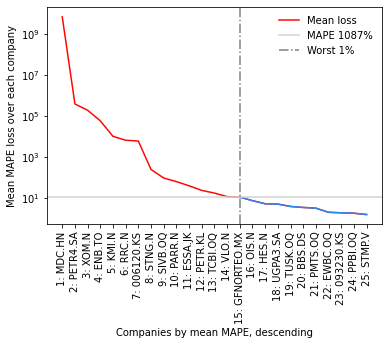

In [ ]:
plot_worst(axts, axmapes, ax1, "MAPE")

array([[<AxesSubplot:title={'center':'market_cap'}>]], dtype=object)

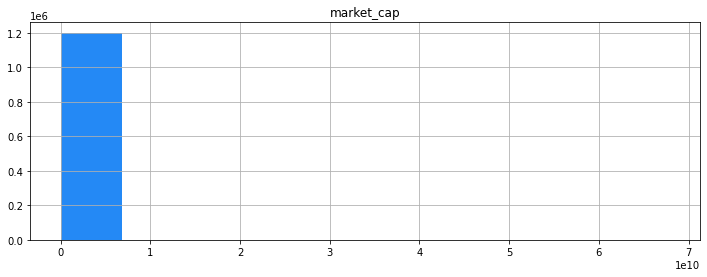

In [ ]:
err.hist()

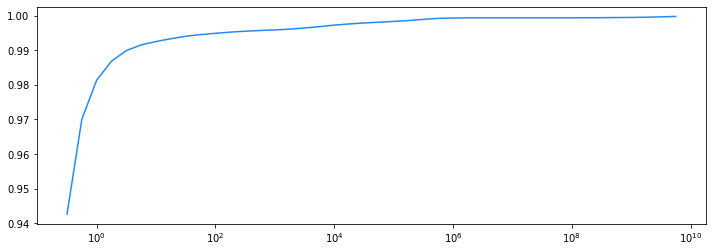

In [ ]:
err_pct = [(10**(x/4), err[err.market_cap < 10**(x/4)].shape[0] / err[~err.market_cap.isna()].shape[0]) for x in range(-2, 40)]
plt.plot(*zip(*err_pct))
plt.xscale("log");

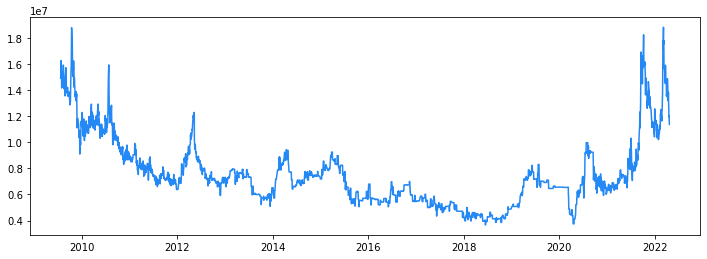

In [ ]:
plt.plot(all_stck.reset_index().query("ticker == 'MDC.HN'").loc[:, ["date", "market_cap"]].set_index("date").squeeze())

### Auto-ARIMAX
Based on the analysis of the below errors, we conclude that AutoARIMAX completely breaks down, and we rather opt for the ARIMAX with the same orders as the corresponding AutoARIMAs.

In [ ]:
%%capture
autoarimax = get_dataset("auto-arimax-4Q-forecast-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()

In [ ]:
autoarimax

market_cap
ticker    year month obs_number              
000001.SZ 2019 1     1           2.348304e+10
                     2           2.352304e+10
                     3           2.355060e+10
                     4           2.356959e+10
                     5           2.358267e+10
...                                       ...
ZION.OQ   2022 4     16          1.530863e+09
                     17          1.021987e+09
                     18          5.147755e+08
                     19          9.798085e+06
                     20         -4.934336e+08

[1244120 rows x 1 columns]

In [ ]:
aaxe = pd_mape(actuals, autoarimax)
reduce(aaxe)

2761235342.180488

array([[<AxesSubplot:title={'center':'market_cap'}>]], dtype=object)

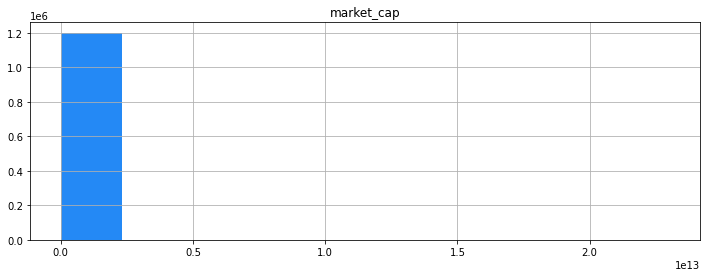

In [ ]:
aaxe.hist()

In [ ]:
aaxe

market_cap
ticker    year month obs_number            
000001.SZ 2019 1     1             0.014444
                     2             0.002379
                     3             0.050230
                     4             0.055158
                     5             0.050774
...                                     ...
ZION.OQ   2022 4     16                 NaN
                     17                 NaN
                     18                 NaN
                     19                 NaN
                     20                 NaN

[1356428 rows x 1 columns]

In [ ]:
reduce(aaxe[aaxe.market_cap < 1e1])

1.4648272821456414

In [ ]:
worst = aaxe.sort_values(by="market_cap", ascending=False).dropna().index.get_level_values(0).unique()
reduce(aaxe[~aaxe.index.get_level_values(0).isin(worst[:100])])

862.818939685969

In [ ]:
ts = []
mape = []

for i, t in enumerate(worst[:500], start=1):
    ts.append(f"{i}: {t}")
    mape.append(reduce(aaxe[aaxe.index.get_level_values(0) == t]))

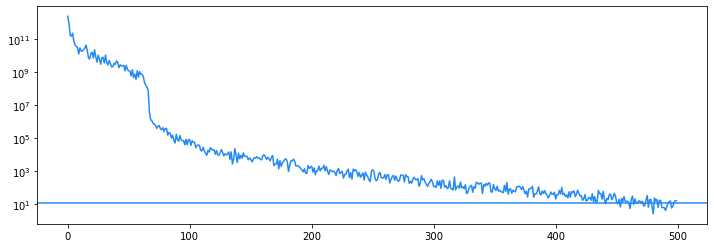

In [ ]:
# plt.plot(ts, mape)
plt.plot(mape)
# plt.xticks(ts, rotation='vertical')
plt.axhline(y=12)
plt.yscale("log");

## Non-parametric

In [ ]:
nn_actuals = (actuals / naive).sort_index()

### TCN

In [ ]:
%%capture
tcn_v00 = get_dataset("tcn-4Q-forecast-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()

In [ ]:
tce = pd_mape(nn_actuals, tcn_v00)
reduce(tce)

0.07708102464675903

In [ ]:
tcw = tce.dropna().groupby(level=0).mean().sort_values(by="market_cap", ascending=False).index.get_level_values(0).unique()
tc1 = int(len(tcw) * 0.01)
tc1

17

In [ ]:
reduce(tce[~tce.index.get_level_values(0).isin(tcw[:tc1])])

0.07575596123933792

In [ ]:
tcts, tcmapes = worst_plot_data(tce, tcw)

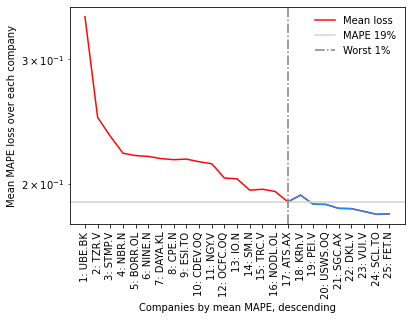

In [ ]:
plot_worst(tcts, tcmapes, tc1, "MAPE")

### TCN-X

In [ ]:
%%capture
# tcnx_v01 = get_dataset("tcnx-4Q-forecast-19-22:v1", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.80%
# tcnx_v02 = get_dataset("tcnx-4Q-forecast-19-22:v4", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.93%
# tcnx_v03 = get_dataset("tcnx-4Q-forecast-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.93%
# tcnx_v05 = get_dataset("tcnx-4Q-forecast-19-22:v5", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 7.99%
# tcnx_v06 = get_dataset("tcnx-4Q-forecast-19-22:v7", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.19%
# tcnx_v07 = get_dataset("tcnx-4Q-forecast-19-22:v6", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.05%
# tcnx_v08 = get_dataset("tcnx-4Q-forecast-19-22:v2", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()  # 7.49%
# tcnx_v10 = get_dataset("tcnx-4Q-forecast-19-22:v3", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 7.91%
# tcnx_v17 = get_dataset("tcnx-4Q-forecast-19-22:v9", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.09%
# tcnx_v31 = get_dataset("tcnx-240-forecast-20-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index().rename(columns=dict(pred="market_cap"))  # 7.21%
# tcnx2_v01 = get_dataset("tcnx-4Q-forecast-19-22:v8", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 8.12%
# tcnx4_v00 = get_dataset("tcnx-4Q-forecast-19-22:v10", project="master").set_index(["ticker", "year", "month", "obs_number"])  # 9.04%
tcnx4_v12 = get_dataset("tcnx-240-forecast-240-19-22:v0", project="master").set_index(["ticker", "year", "month", "obs_number"]).sort_index()  #


In [ ]:
txe = pd_mape(nn_actuals, tcnx4_v12.rename(columns=dict(pred="market_cap")))
reduce(txe)

0.10422436892986298

In [ ]:
txw = txe.dropna().groupby(level=0).mean().sort_values(by="market_cap", ascending=False).index.get_level_values(0).unique()
tx1 = int(len(txw) * 0.01)
tx1

17

In [ ]:
reduce(txe[~txe.index.get_level_values(0).isin(txw[:tx1])])

0.09475183486938477

In [ ]:
txts, txmapes = worst_plot_data(txe, txw)

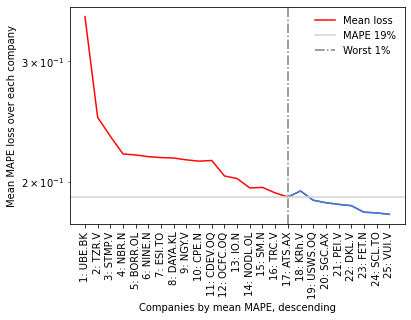

In [ ]:
plot_worst(txts, txmapes, tx1, "MAPE")

# Volatility

## Baseline

### Vix last non-na date 1 month ahead forecast

In [ ]:
vix_data = macro.loc[:,["date","vix"]]

In [ ]:
vix_ = vix_data[(vix_data.date > "2018-12-01") & (vix_data.date < "2022-04-01")].copy()
vix_["year"], vix_["month"] = vix_["date"].dt.year, vix_["date"].dt.month
vix_ = vix_.drop(columns=["date"])
vix_ = vix_.sort_values(["year","month"])[["year","month","vix"]]

vix_formatted = pd.DataFrame(columns=["year", "month", "vix"])
for (year, month), df in vix_.groupby(by=["year", "month"]):
    
    vix_formatted = vix_formatted.append(df.ffill().iloc[-1,:], ignore_index=True)

vix_formatted = vix_formatted.astype({"year":int, "month":int})
vix_formatted.iloc[1:,2] = vix_formatted.iloc[:-1, 2] 
vix_f = vix_formatted.drop(0,axis=0).rename(columns={"vix":"standard_div"}).set_index(["year","month"])/100

Unfortunately this does not make that much sense, and some more work would be needed to done for the vix to work as an accurate extrapolation measure

### Naïve variance

In [ ]:
naive_std = stds.copy()

naive_std = naive_std.groupby(by=["ticker", "year", "month"]).last(1).reset_index()

naive_std["month"] = naive_std["month"] + 1
adj = naive_std.month == 13
naive_std.loc[adj, "month"] = 1
naive_std.loc[adj, "year"] = naive_std.loc[adj, "year"] + 1

naive_std = naive_std.set_index(["ticker", "year", "month"]).sort_index()
naive_std = naive_std.loc[~((naive_std.index.get_level_values(1) == 2022) & (naive_std.index.get_level_values(2) == 5))]

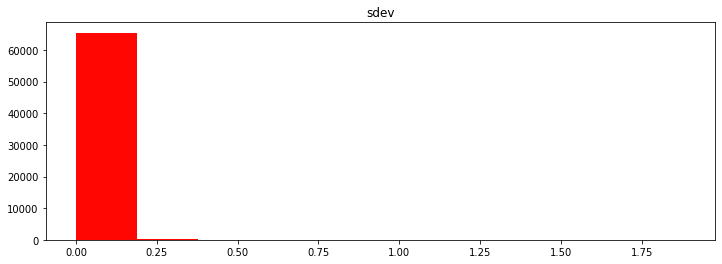

In [ ]:
 pd_mae(stds, naive_std).hist(grid=False, color=main2);

In [ ]:
get_losses(pd_mae, stds, naive_std)

(sdev    0.014357
 dtype: float64, sdev    0.013367
 dtype: float64)

## Garch

In [ ]:
%%capture
garch = get_dataset("garch-4Q-forecast-19-22:v1", project="master").set_index(["ticker", "year", "month"]).sort_index()

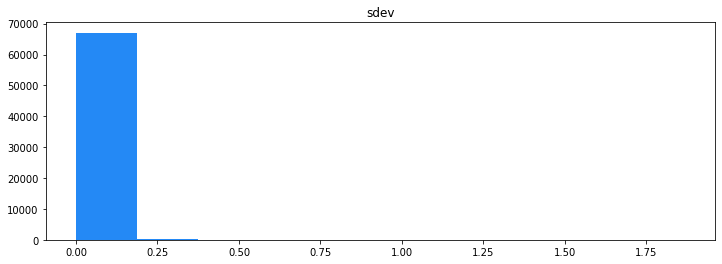

In [ ]:
pd_mae(stds, garch).hist(grid=False);

In [ ]:
get_losses(pd_mae, stds, garch)

(sdev    0.015908
 dtype: float64, sdev    0.014563
 dtype: float64)

In [ ]:
nats, namapes = worst_plot_data(nae, naw)

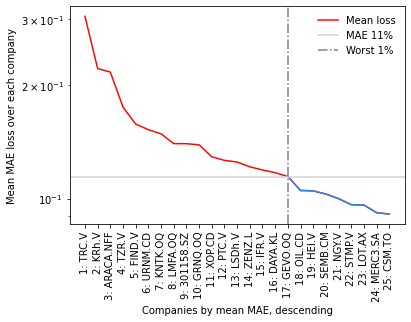

In [ ]:
plot_worst(nats, namapes, na1, "MAE")

In [ ]:
f"Garch mean: {pd_mae(stds, garch).mean().item():.4f}",  f"Naive mean: {pd_mae(stds, naive_std).mean().item():.4f}"

('Garch mean: 0.0159', 'Naive mean: 0.0144')

## TCN

In [ ]:
tcn_sdev = get_dataset("sdev-tcn-240-forecast-20-19-22:v0", project="master").set_index(["ticker", "year", "month"]).sort_index()

In [ ]:
get_losses(pd_mae, stds, tcn_sdev)

(sdev    0.015275
 dtype: float64, sdev    0.014199
 dtype: float64)

## TCN-X

In [ ]:
tcn_mv_sdev = get_dataset("sdev-tcnx-240-forecast-20-19-22:v1", project="master").set_index(["ticker", "year", "month"]).sort_index()

In [ ]:
get_losses(pd_mae, stds, tcn_mv_sdev)

(sdev    0.01488
 dtype: float64, sdev    0.013801
 dtype: float64)

# Visualization

In [ ]:
def plot_pred(ticker, forec):
    actual = all_stck[(all_stck.date < "2020-01-01") & (all_stck.date >= "2019-01-01") & (all_stck.ticker == ticker)].drop(columns="ticker").set_index("date")
    norm = actual.iloc[-1, :].item()
    actual /= norm
    future = all_stck[(all_stck.date.dt.year == 2020) & (all_stck.date.dt.month == 1) & (all_stck.ticker == ticker)].drop(columns="ticker").set_index("date").iloc[:20, :]
    future /= norm
    
    f = forec.loc[(ticker, 2020, 1)].to_numpy()
    idx = future.index

    l = min(len(f), len(idx))

    pred = pd.DataFrame(f[:l], index=idx[:l])
    plt.plot(actual, label=ticker)
    plt.plot(pred, label="Predicted")
    plt.plot(future, color=main, linestyle="-.", label="Actual")
    plt.legend(frameon=False)
    plt.xlabel("Dates")
    plt.ylabel("Normalized market cap")
    plt.show();

In [ ]:
def get_dates(data_df):
    to_date = data_df.drop(columns=["sdev"]).copy()
    to_date["day"] = 31 
    to_date = to_date.reset_index().drop(columns=["ticker"])
    pd.to_datetime(to_date)

In [ ]:
def plot_many_forecast(forecasts, forecast_name, n_slice="all"):
    tickers = all_stck.ticker.unique()
    dates = get_dates(forecasts)
    
    if n_slice != "all": 
        tickers = tickers[n_slice]
    
    for ticker in tickers:
        forecast = forecasts[forecasts.index.get_level_values(0) == ticker].values
        date = dates[forecasts.index.get_level_values(0) == ticker]
        plt_ret = plt.plot(date.values,forecast, color=main, alpha=0.2)
    plt_ret[0].set_label(forecast_name)
    ticker = tickers[0]
    plt.xticks(pd.date_range(start=date.iloc[0], end=date.iloc[-1], freq="12M"))
    plt.ylabel("Standard deviation")
    plt.xlabel("Months in test set")
    plt.legend(frameon=False)


In [ ]:
def plot_general(actuals, ticker, forecast=None, forecast_label=None, baseline=None, baseline_label="", ylab=""):
    this_comp = actuals[actuals.index.get_level_values(0) == ticker]
    dates_actuals = get_dates(actuals)
    plt.plot(dates_actuals[actuals.index.get_level_values(0) == ticker], this_comp.values, label=f"{ticker} actual")
    plt.ylabel(ylab)
    

    if forecast is not None:
        dates_forecast = get_dates(forecast)    
        plt.plot(dates_forecast[forecast.index.get_level_values(0) == ticker],forecast[forecast.index.get_level_values(0) == ticker].values, label=f"{forecast_label}")

    if baseline is not None:
        dates_baseline = get_dates(baseline)
        plt.plot(dates_baseline[baseline.index.get_level_values(0) == ticker], baseline[baseline.index.get_level_values(0) == ticker].values, label=f"{baseline_label}", color=main2, linestyle="-.", alpha=.5)
    plt.legend(frameon=False)
    plt.xticks(pd.date_range(start=dates_actuals.iloc[0], end=dates_actuals.iloc[-1], freq="12MS"))

In [ ]:
def distribution_loss(actuals, estimates):
    nae = pd_mae(stds, estimates)
    naw = nae.dropna().groupby(level=0).mean().sort_values(by="sdev", ascending=False).index.get_level_values(0).unique()
    
    loss_means = []
    for worst_i in range(len(naw)):
        loss_means.append(nae[~nae.index.get_level_values(0).isin(naw[:worst_i])].mean().item())
    return loss_means

def distribution_plot(distribution_loss_1, label_1, distribution_loss_2=None, label_2=None, ylab=None, xlab=None):
    plt.plot(distribution_loss_1, label=label_1)
    
    x_value = None
    y_value = None
    
    if distribution_loss_2 is not None:
        
        sign = distribution_loss_1[0] - distribution_loss_2[0]
        
        for i in range(len(distribution_loss_1)):
            
            if sign*(distribution_loss_1[i] - distribution_loss_2[i]) < 0:
                x_value = i
                y_value = distribution_loss_1[i]
                break
        plt.plot(distribution_loss_2, label=label_2)
        plt.axhline(y_value, color="grey", linestyle="-.")
        plt.axvline(x_value, color="grey", linestyle="-.")
    plt.legend(frameon=False)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

## Visualize forecasts

In [ ]:
forec = tcnx_v08.sort_index()
# forec = arimax

In [ ]:
tickers = [t for t in all_stck.ticker.unique() if "OL" in t]
ticker = tickers[1]
ticker

'AKRBP.OL'

### Market cap forecasts

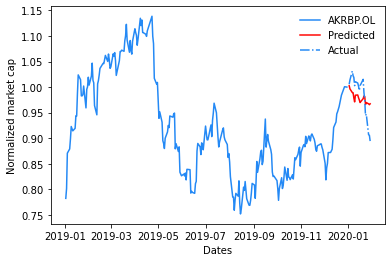

In [ ]:
plot_pred(ticker, forec)

In [ ]:
tcn_v00.iloc[:50_000].to_excel("tcn_v00.xlsx")

In [ ]:
for ticker in tickers:
    plot_pred(ticker, tcn_v00)

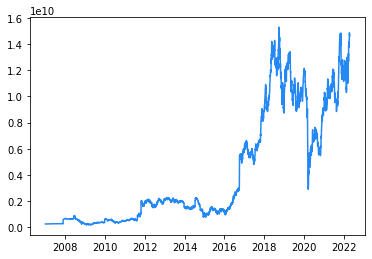

In [ ]:
plt.plot(all_stck.loc[all_stck.ticker == "AKRBP.OL", ["date", "market_cap"]].set_index("date"));

### Variance plots


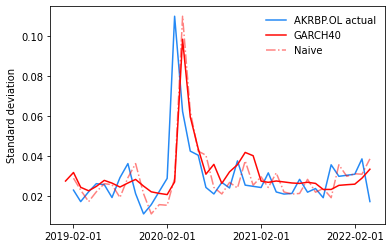

In [ ]:
plot_general(stds[stds.index.get_level_values(2) != 1], "AKRBP.OL", forecast=garch, forecast_label="GARCH40", baseline=naive_std, baseline_label="Naive", ylab="Standard deviation")

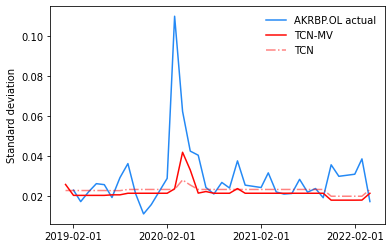

In [ ]:
plot_general(stds[stds.index.get_level_values(2) != 1], "AKRBP.OL", forecast=tcn_mv_sdev, forecast_label="TCN-MV",baseline=tcn_sdev, baseline_label="TCN", ylab="Standard deviation")

In [ ]:
def _internal_standard_deviation(forecasts):
    standard_divs = {}
    
    for ticker, df in forecasts.groupby(level=["ticker"]):
        standard_divs[ticker] = df.sdev.std()
    return standard_divs, np.mean([item for key, item in standard_divs.items()])

In [ ]:
def internal_standard_deviation_plot(name_to_forecast_dict, color_order, ):
    all_stds = {}
    for name, forecast in name_to_forecast_dict.items():
        _, mean_std = _internal_standard_deviation(forecast)
        all_stds[name] = mean_std
    
    cats, internal_stds = [key for key, item in all_stds.items()], [item for key, item in all_stds.items()]
    plt.bar(cats, internal_stds, color=color_order)
    plt.ylabel("Mean std over time")
    
    return all_stds

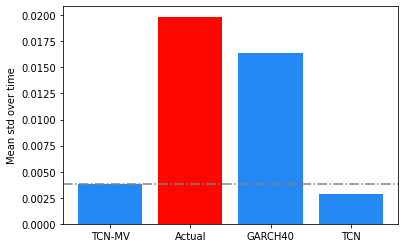

In [ ]:
name_to_forecast = {"TCN-MV":tcn_mv_sdev, "Actual":stds, "GARCH40":garch, "TCN":tcn_sdev}

all_stds = internal_standard_deviation_plot(name_to_forecast, [main, main2, main, main])
plt.axhline(all_stds["TCN-MV"], color="grey", linestyle="-.");

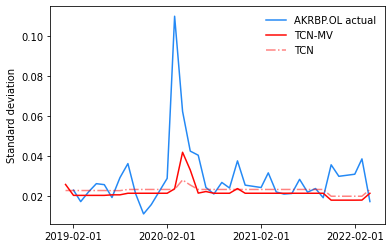

In [ ]:
plot_general(stds[stds.index.get_level_values(2) != 1], "AKRBP.OL", forecast=tcn_mv_sdev, forecast_label="TCN-MV", baseline=tcn_sdev,baseline_label="TCN", ylab="Standard deviation")

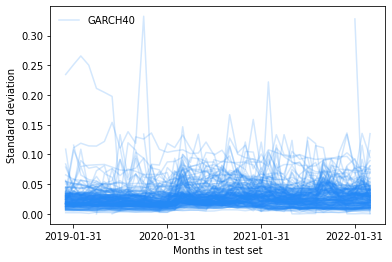

In [ ]:
plot_many_forecast(garch, "GARCH40", slice(0,200))

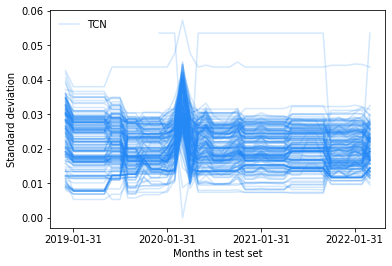

In [ ]:
plot_many_forecast(tcn_mv_sdev, "TCN", slice(0,200))

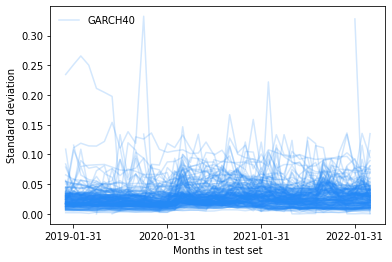

In [ ]:
plot_many_forecast(garch, "GARCH40", n_slice=slice(0,200))

In [ ]:
garch_dist = distribution_loss(stds,garch)
tcn_mv_dist = distribution_loss(stds,tcn_mv_sdev)
tcn_dist = distribution_loss(stds,tcn_sdev)

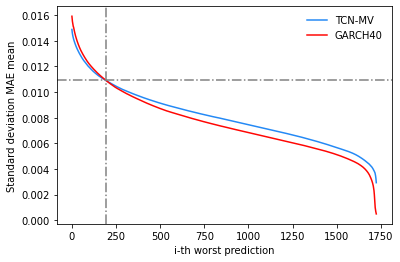

In [ ]:
distribution_plot(tcn_mv_dist, label_1="TCN-MV", distribution_loss_2=garch_dist, label_2="GARCH40", ylab="Standard deviation MAE mean", xlab="i-th worst prediction")

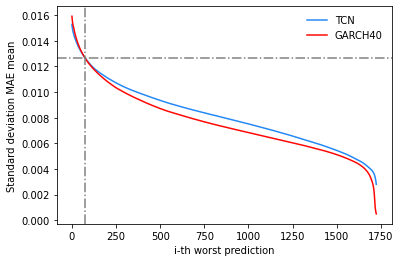

In [ ]:
distribution_plot(tcn_dist, label_1="TCN", distribution_loss_2=garch_dist, label_2="GARCH40", ylab="Standard deviation MAE mean", xlab="i-th worst prediction")

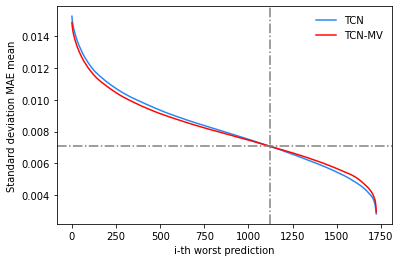

In [ ]:
distribution_plot(tcn_dist, label_1="TCN", distribution_loss_2=tcn_mv_dist, label_2="TCN-MV", ylab="Standard deviation MAE mean", xlab="i-th worst prediction")

## Visualize MoM returns

In [ ]:
wide = all_stck.pivot(index="date", columns="ticker")

In [ ]:
wide["year"], wide["month"] = wide.index.year, wide.index.month

# wide = wide.loc[(wide.year >= 2018) & (wide.year < 2019) & (wide.month > 6)]
ret = wide.loc[(wide.year >= 2000) & (wide.year < 2019)]

In [ ]:
first, last = ret.groupby(["year", "month"]).first(), ret.groupby(["year", "month"]).last()

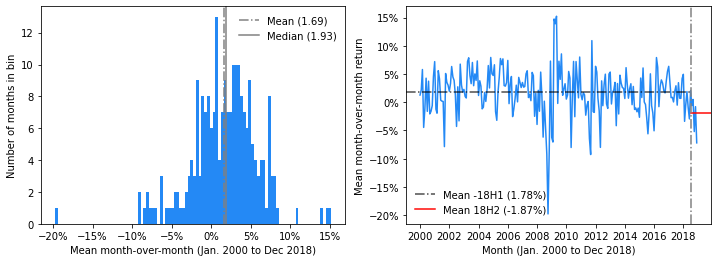

In [ ]:
date_range = pd.date_range(periods=len(chg), end="2018-12-01", freq="M")
last_6 = chg.loc[(chg.index.get_level_values(0) == 2018) & (chg.index.get_level_values(1) > 6)]
crack = 0.935

# Setup
fig, (ax0, ax1) = plt.subplots(ncols=2)


# Histogram
c, bins, containers = ax0.hist(chg.values, bins=100);
# ax0.set_xticklabels(labels=bins, rotation=0);
ax0.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

ax0.set_xlabel("Mean month-over-month (Jan. 2000 to Dec 2018)")
ax0.set_ylabel("Number of months in bin")

mean, median = chg.mean(), chg.median()

ax0.axvline(x=mean, color="grey", linestyle="-.", label=f"Mean ({mean*100:.2f})")
ax0.axvline(x=median, color="grey", linestyle="-", label=f"Median ({median*100:.2f})")

ax0.legend(frameon=False);


# Line chart
ax1.plot(date_range, chg.values)

ax1.axhline(y=chg[:-6].mean(), color="black", label=f"Mean -18H1 ({chg[:-6].mean()*100:.2f}%)", xmin=0, xmax=crack, linestyle="-.", alpha=0.7)
ax1.axhline(y=last_6.mean(), color=main2, label=f"Mean 18H2 ({last_6.mean()*100:.2f}%)", xmin=crack, xmax=1,)

ax1.axvline(x=date_range[-6], linestyle="-.", color="grey")

ax1.set_xlabel("Month (Jan. 2000 to Dec 2018)")
ax1.set_ylabel("Mean month-over-month return")

ax1.yaxis.set_major_formatter(PercentFormatter(decimals=0, xmax=1))


ax1.legend(loc=3, frameon=False);

In [ ]:
date_range[-6]

Timestamp('2018-06-30 00:00:00', freq='M')

## Plot 1% cutoff for all

## Create overfitting visualization

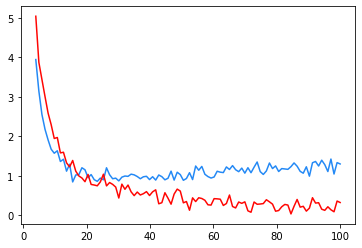

In [ ]:
xs = np.linspace(0.2, 5, 100)
y1 = 1 / xs + np.log(xs) / 1.5 + np.random.normal(scale=0.1, size=xs.size)
y2 = 1 / xs + np.random.normal(scale=0.1, size=xs.size)

plt.plot(xs*20, y1)
plt.plot(xs*20, y2);